### Comparing the models Performance

#### Import required  libraries
* install the below packages if missing

```bash
    %pip install pandas numpy tensorflow scikit-learn plotly matplotlib
```

In [32]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from tensorflow.keras.layers import Input, LSTM, Dropout, Dense, Bidirectional
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


#### Data Preparation 

####  1.1 Set the stock symbol

In [36]:
stock='GOOG'
time_step=10
# Set the number of weeks for testing
n_test_weeks = 10  

**Read the data File**

In [39]:
# Normalizer class for scaling features
class Normalizer():
    def __init__(self):
        self.mu = None
        self.sd = None

    def fit_transform(self, x):
        x = np.array(x)
        self.mu = np.mean(x, axis=0, keepdims=True)
        self.sd = np.std(x, axis=0, keepdims=True)
        return (x - self.mu) / self.sd

    def inverse_transform(self, x):
        return (x * self.sd) + self.mu

# Load stock, earnings, and insider transaction data
df_stock = pd.read_csv(f'/Users/sunithakosireddy/Downloads/data/{stock}_weekly_adjusted.csv',
                       header=0, index_col=0, parse_dates=[0], thousands=',')
df_earnings = pd.read_csv(f'/Users/sunithakosireddy/Downloads/data/{stock}_earnings.csv',
                          header=0, parse_dates=['fiscalDateEnding', 'reportedDate'])
df_insider = pd.read_csv(f'/Users/sunithakosireddy/Downloads/data/{stock}_insider_transactions.csv',
                         header=0, parse_dates=['transaction_date'])

**Prepare the dataset**

In [42]:
# Prepare features: surprise percentages and insider transactions
closing_prices = df_stock['Adjusted Close'].values
volume = df_stock['Volume'].values
surprise_percentage = df_earnings['surprisePercentage'].values
insider_transactions = df_insider['shares'].values

min_length = min(len(closing_prices), len(surprise_percentage), len(insider_transactions))

price_dates = df_stock.index[:min_length]
surprise_array = np.zeros(len(price_dates))

# Map earnings surprise percentages to corresponding quarters
for _, row in df_earnings.iterrows():
    quarter_end = row['fiscalDateEnding']
    quarter_start = quarter_end - pd.DateOffset(months=3)
    within_quarter_mask = (price_dates >= quarter_start) & (price_dates <= quarter_end)
    num_weeks = np.sum(within_quarter_mask)
    if num_weeks > 0:
        surprise_array[within_quarter_mask] = row['surprisePercentage'] / num_weeks

# Merge insider transactions with combined data
df_insider['Week'] = df_insider['transaction_date'].dt.to_period('W').apply(lambda r: r.start_time)
weekly_transactions = df_insider.groupby(['Week', 'acquisition_or_disposal'])['shares'].sum().unstack(fill_value=0)
weekly_transactions.columns = ['Disposal', 'Acquisition']
weekly_transactions.reset_index(inplace=True)

combined_df = pd.DataFrame({
    'Date': df_stock.index[:min_length],
    'Closing Prices': closing_prices[:min_length],
    'Surprise Percentage': surprise_array[:min_length],
    'Insider Transactions': insider_transactions[:min_length],
    'Volume': volume[:min_length]
})
combined_df['Week'] = combined_df['Date'].dt.to_period('W').apply(lambda r: r.start_time)
combined_df = combined_df.merge(weekly_transactions, on='Week', how='left').fillna(0)

# Add market impact (Acquisition - Disposal)
combined_df['Market Impact'] = combined_df['Acquisition'] - combined_df['Disposal']

# Prepare data for LSTM
features = ['Closing Prices', 'Surprise Percentage', 'Insider Transactions', 'Volume', 'Market Impact']
combined_data = combined_df[features].values

normalizer = Normalizer()
combined_data_scaled = normalizer.fit_transform(combined_data)

# Create dataset for LSTM
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step), :])
        y.append(data[i + time_step, 0])  # Predict closing price
    return np.array(X), np.array(y)



**Split the training dataset and testset**

In [45]:
X, y = create_dataset(combined_data_scaled, time_step)
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
n_features = len(features)  # Number of features

# Ensure you have enough data for reshaping (time_step * n_features)
X_test_data = combined_data_scaled[-(n_test_weeks + time_step):]

# Now reshape to (samples, time_step, features)
X_test = []
y_test = []
for i in range(time_step, len(X_test_data)):
    X_test.append(X_test_data[i-time_step:i])
    y_test.append(X_test_data[i, 0])  # We predict the closing price, so we take the first column

# Convert to numpy arrays
X_test = np.array(X_test)
y_test = np.array(y_test)

# Ensure that the shape is correct
assert X_test.shape[1] == time_step, f"Expected time steps: {time_step}, but got: {X_test.shape[1]}"
assert X_test.shape[2] == n_features, f"Expected features: {n_features}, but got: {X_test.shape[2]}"

#####  1.2 Method to create data sets with lags

**LSTM MODEL  : Build Train**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
Layers: 2, Learning Rate: 0.001, Batch Size: 16, MSE: 9.28, MAE: 2.43, DA MSE: 21.58, DA MAE: 4.16


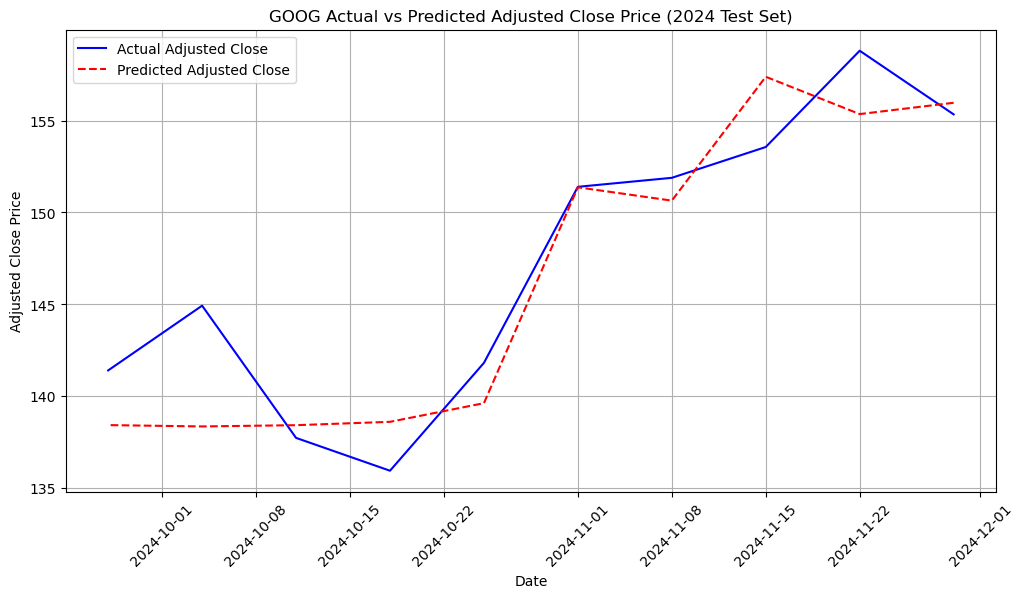

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
Layers: 2, Learning Rate: 0.001, Batch Size: 32, MSE: 8.82, MAE: 2.29, DA MSE: 21.43, DA MAE: 3.82


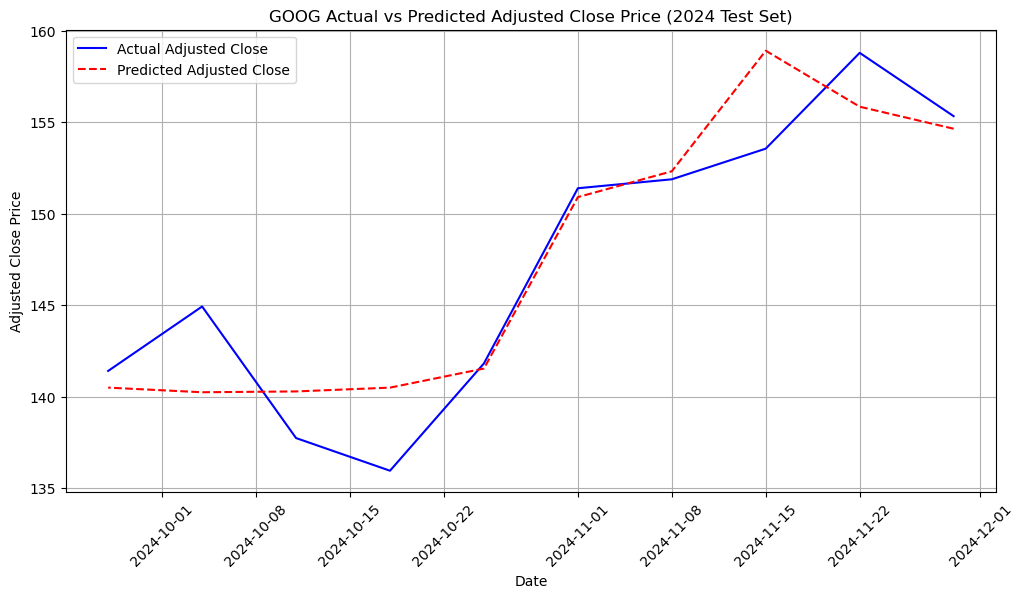

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
Layers: 2, Learning Rate: 0.001, Batch Size: 64, MSE: 8.76, MAE: 2.33, DA MSE: 19.18, DA MAE: 3.75


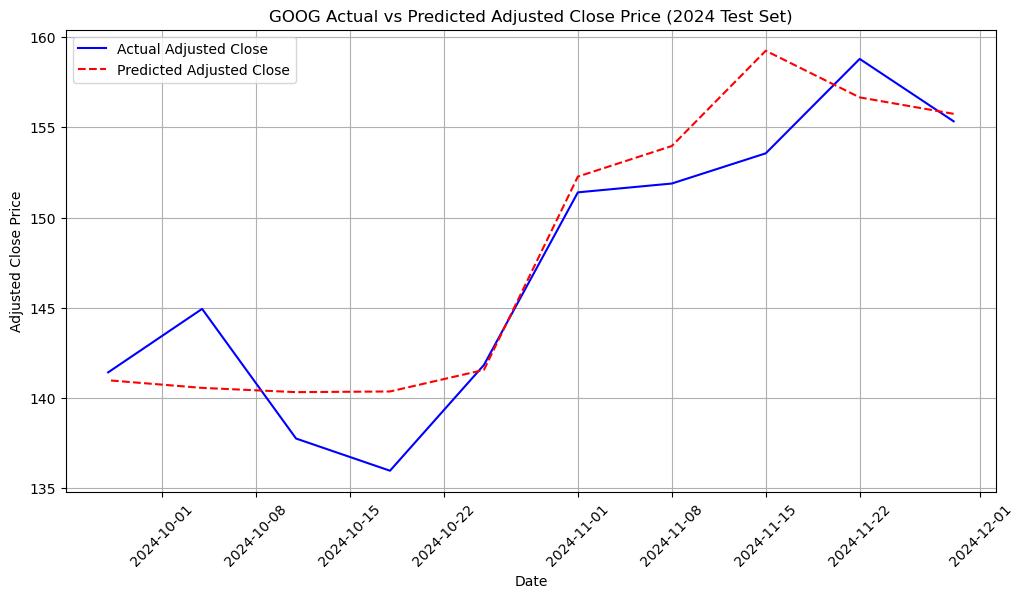

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
Layers: 2, Learning Rate: 0.0005, Batch Size: 16, MSE: 15.31, MAE: 3.01, DA MSE: 21.59, DA MAE: 4.21


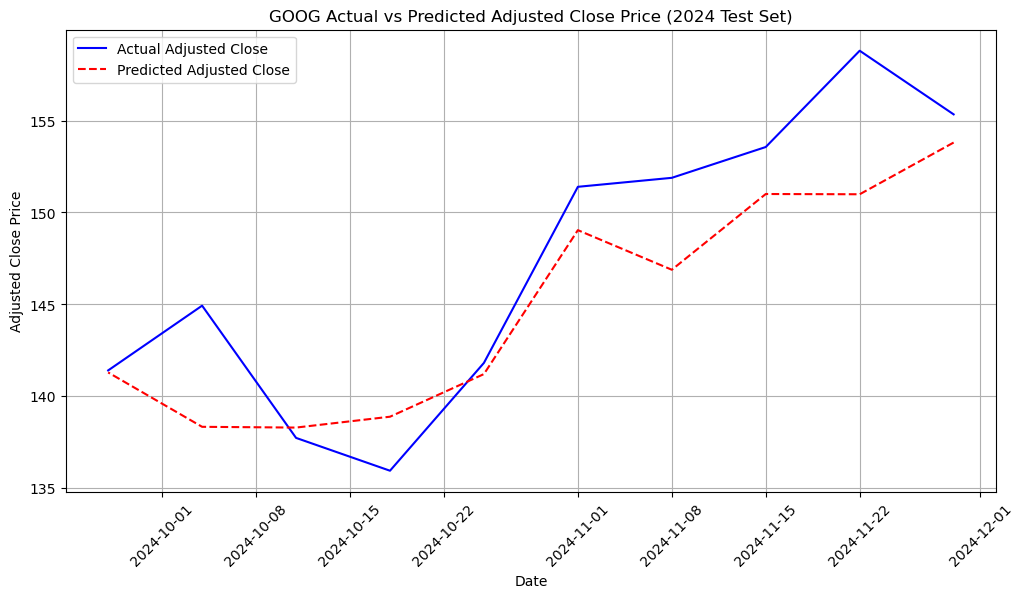

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
Layers: 2, Learning Rate: 0.0005, Batch Size: 32, MSE: 8.32, MAE: 2.30, DA MSE: 18.38, DA MAE: 3.78


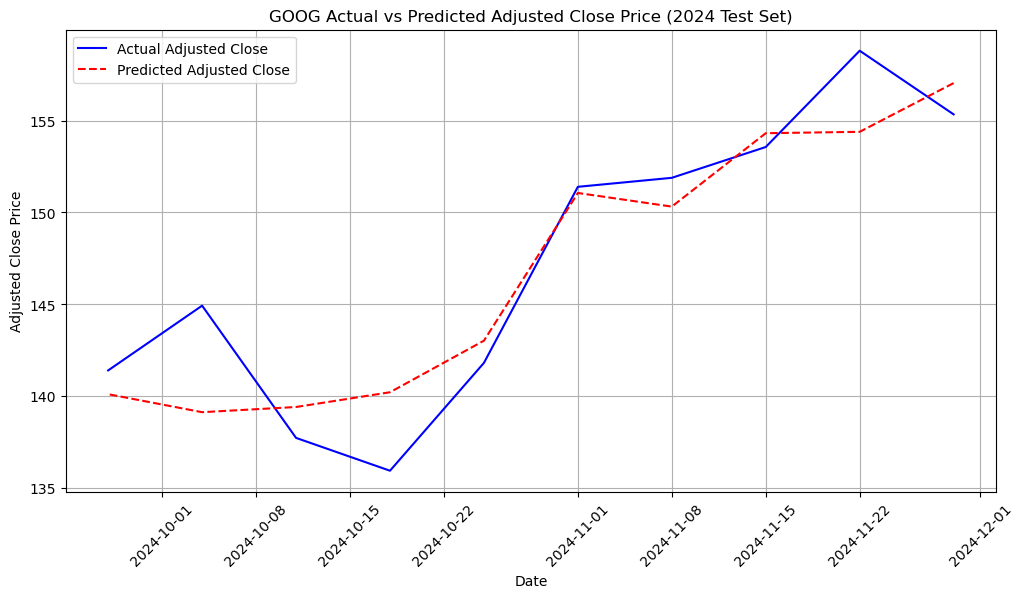

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
Layers: 2, Learning Rate: 0.0005, Batch Size: 64, MSE: 8.87, MAE: 2.56, DA MSE: 16.19, DA MAE: 3.45


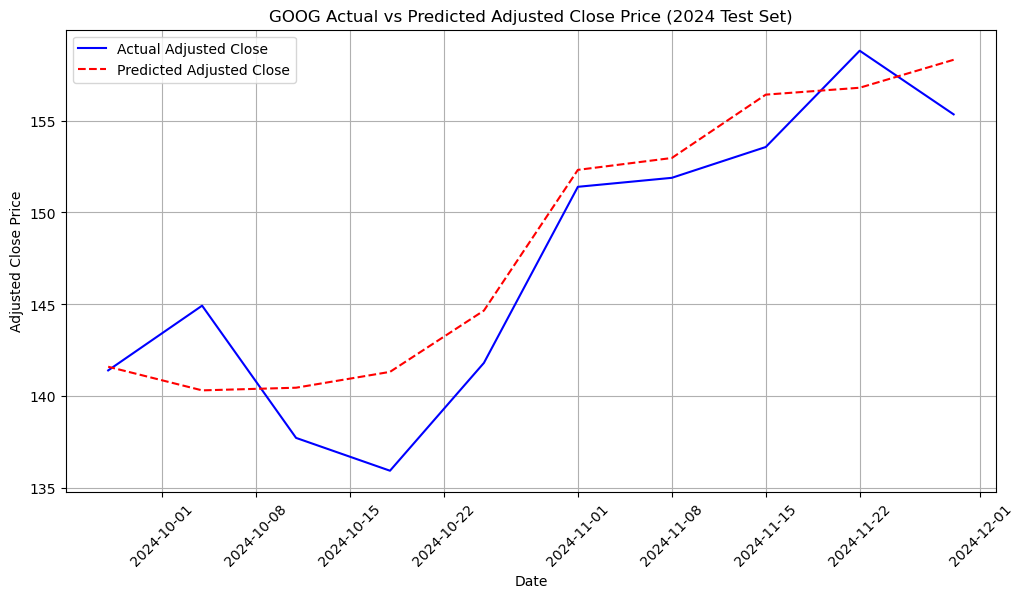

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
Layers: 3, Learning Rate: 0.001, Batch Size: 16, MSE: 8.03, MAE: 2.24, DA MSE: 18.38, DA MAE: 3.82


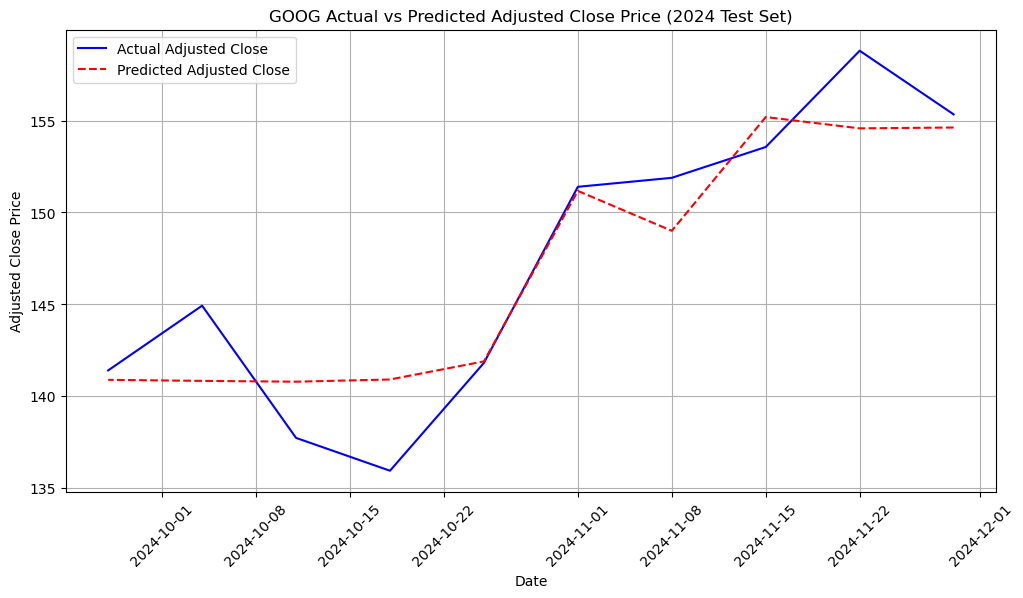

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
Layers: 3, Learning Rate: 0.001, Batch Size: 32, MSE: 7.38, MAE: 2.21, DA MSE: 18.06, DA MAE: 3.77


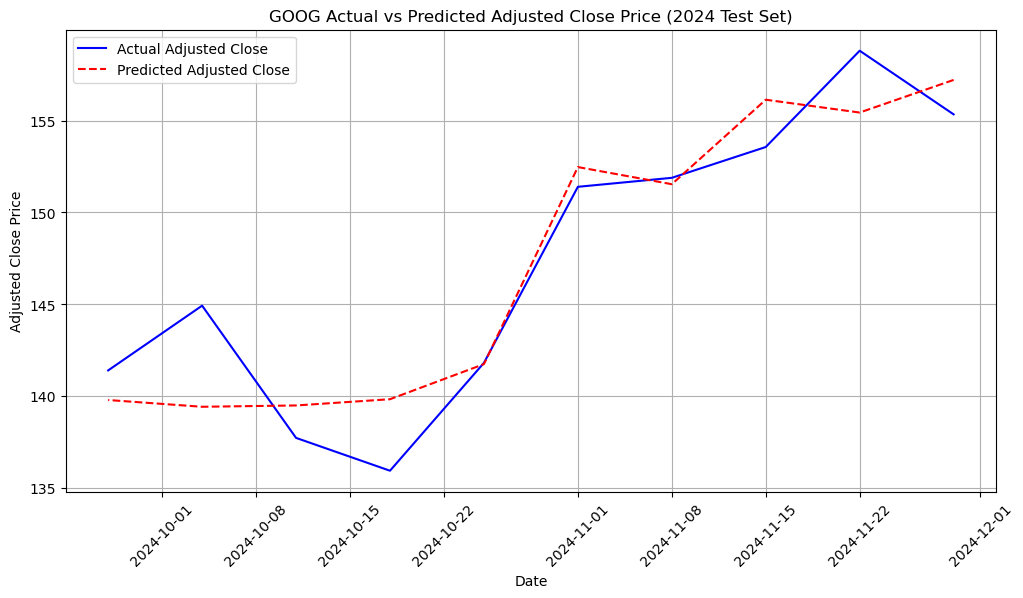

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
Layers: 3, Learning Rate: 0.001, Batch Size: 64, MSE: 14.91, MAE: 3.14, DA MSE: 22.60, DA MAE: 4.20


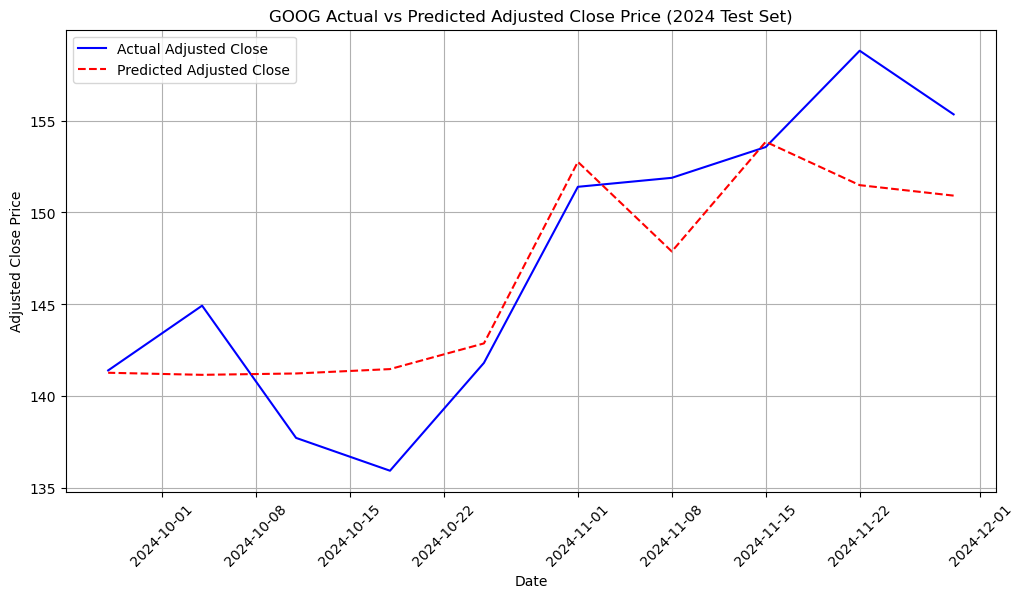

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
Layers: 3, Learning Rate: 0.0005, Batch Size: 16, MSE: 7.80, MAE: 2.41, DA MSE: 17.82, DA MAE: 3.87


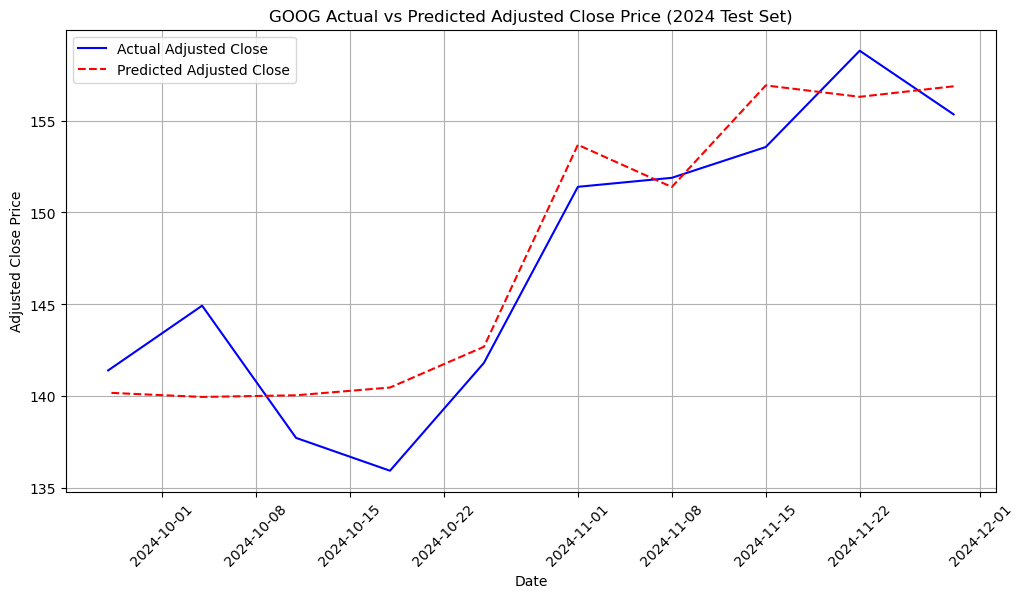

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
Layers: 3, Learning Rate: 0.0005, Batch Size: 32, MSE: 11.15, MAE: 2.82, DA MSE: 19.04, DA MAE: 4.00


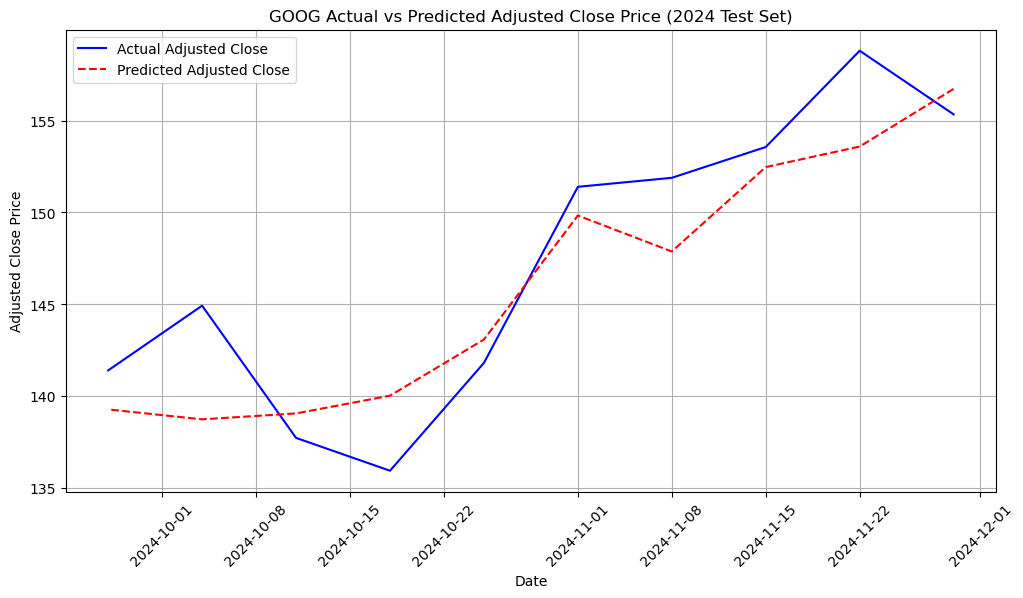

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
Layers: 3, Learning Rate: 0.0005, Batch Size: 64, MSE: 14.56, MAE: 3.25, DA MSE: 22.31, DA MAE: 4.23


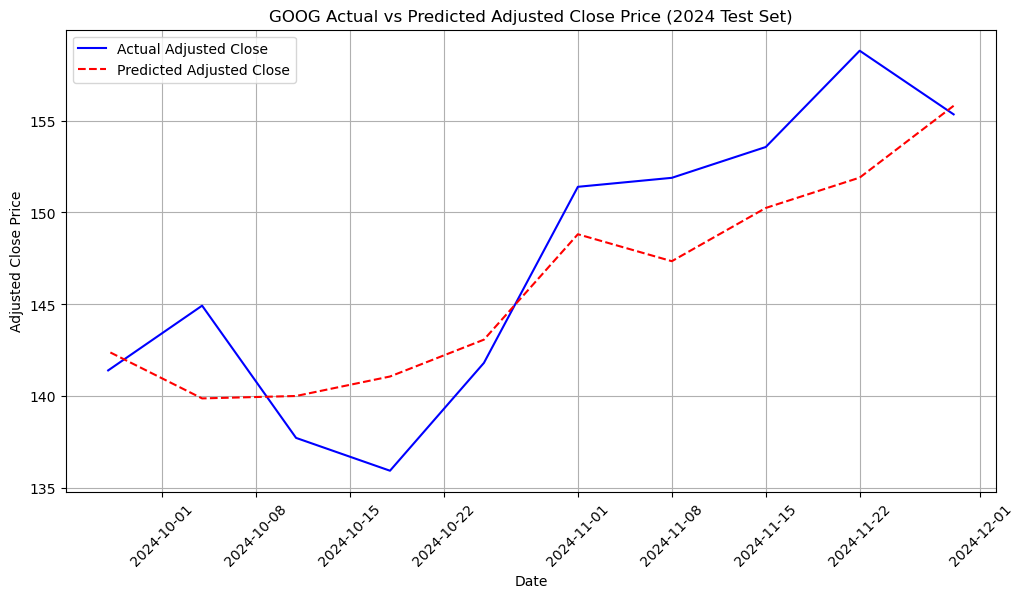

 Layers  Learning Rate  Batch Size       MSE      MAE    DA MSE   DA MAE
      2         0.0010          16  9.277338 2.425135 21.582613 4.161938
      2         0.0010          32  8.824242 2.287929 21.426687 3.824851
      2         0.0010          64  8.763458 2.325994 19.175272 3.747358
      2         0.0005          16 15.313551 3.006184 21.585196 4.212306
      2         0.0005          32  8.321735 2.300663 18.382309 3.776245
      2         0.0005          64  8.871652 2.558868 16.185723 3.446477
      3         0.0010          16  8.031570 2.237319 18.378008 3.816027
      3         0.0010          32  7.378875 2.206078 18.059736 3.765249
      3         0.0010          64 14.909160 3.136083 22.600356 4.203680
      3         0.0005          16  7.804555 2.406579 17.822395 3.868758
      3         0.0005          32 11.154077 2.824432 19.042656 4.004683
      3         0.0005          64 14.562021 3.254408 22.312946 4.231119


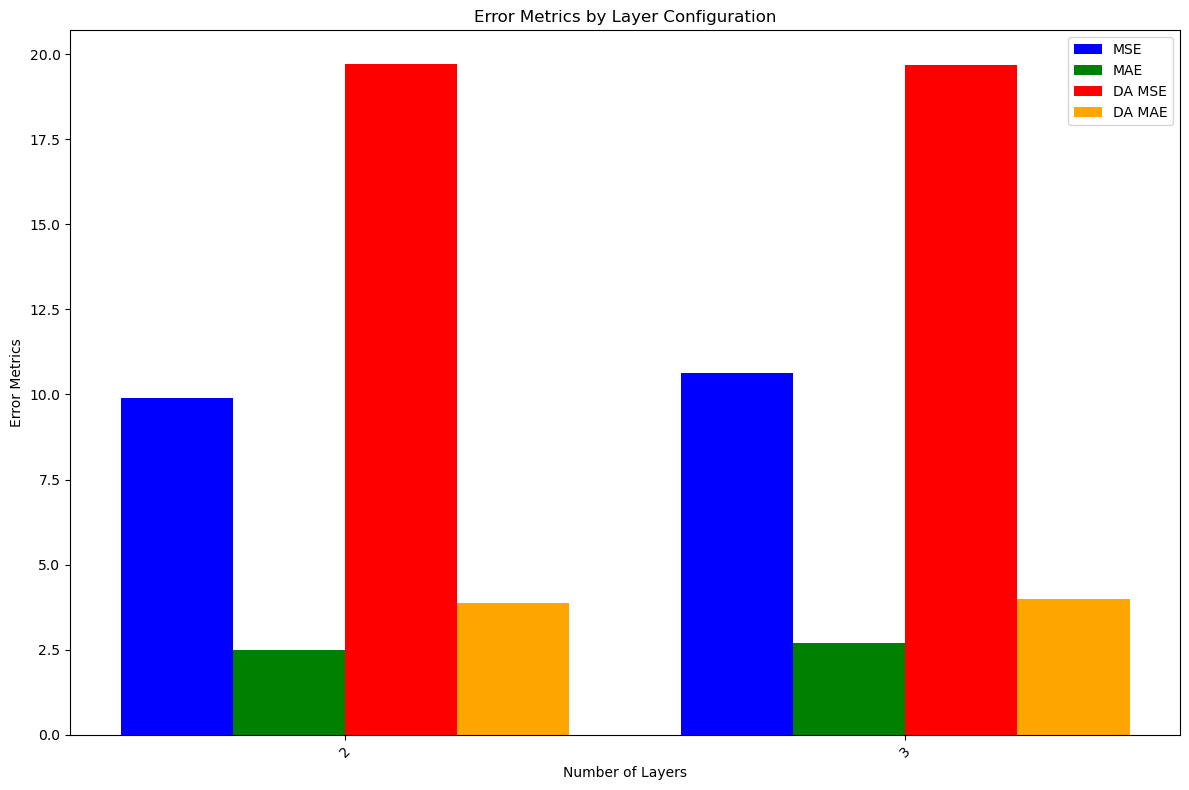

In [53]:
# Define LSTM model
def build_model(input_shape, layers, learning_rate):
    model = tf.keras.Sequential()
    model.add(Input(shape=input_shape))
    model.add(Bidirectional(LSTM(100, return_sequences=True, kernel_regularizer=regularizers.l2(0.01))))
    model.add(Dropout(0.4))
    for _ in range(layers - 1):
        model.add(LSTM(100, return_sequences=True, kernel_regularizer=regularizers.l2(0.01)))
        model.add(Dropout(0.4))
    model.add(LSTM(50, return_sequences=False, kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dropout(0.3))
    model.add(Dense(25, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='Huber')
    return model

# Hyperparameters to tune for LSTM
#learning rates, num layers, batch sizes
learning_rates = [0.001, 0.0005]
num_layers = [2, 3]
batch_sizes = [16, 32, 64]

metrics = []
for layers in num_layers:
    for lr in learning_rates:
        for batch_size in batch_sizes:
            model = build_model((X_train.shape[1], X_train.shape[2]), layers, lr)
            early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
            lr_scheduler = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, min_lr=1e-6)
            
            # Now fit the model and predict
            model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=batch_size, epochs=100, callbacks=[early_stop, lr_scheduler], verbose=0)
            predictions = model.predict(X_test)
            
            # Inverse transformation of the predictions (only for Closing Prices)
            predictions_inv = normalizer.inverse_transform(
                np.column_stack((predictions, np.zeros((predictions.shape[0], len(features) - 1)))))[:, 0]  # Only the first column (Closing Prices)

            y_test_inv = normalizer.inverse_transform(
                np.column_stack((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], len(features) - 1)))))[:, 0]  # Only the first column (Closing Prices)

            # Get the 2024 test data range for plotting
            # Start from one time step before the 2024 data starts
            test_start_date = '2024-09-24'  
            test_end_date = '2024-11-30'
            
            # Filter test data based on the 2024 range
            test_data = df_stock[(df_stock.index >= test_start_date) & (df_stock.index <= test_end_date)]
            
            # Ensure that the number of test data points matches the predictions (should now be 10)
            assert len(test_data) == len(y_test_inv), f"Number of test data points: {len(test_data)} doesn't match predictions: {len(y_test_inv)}"
            
            # Calculate differential adjusted (DA) price
            da_prices = np.diff(y_test_inv)

            # Print error metrics and DA 
            mse = mean_squared_error(y_test_inv, predictions_inv)
            mae = mean_absolute_error(y_test_inv, predictions_inv)
            da_mse = mean_squared_error(da_prices, np.diff(predictions_inv))
            da_mae = mean_absolute_error(da_prices, np.diff(predictions_inv))
            
            print(f"Layers: {layers}, Learning Rate: {lr}, Batch Size: {batch_size}, MSE: {mse:.2f}, MAE: {mae:.2f}, DA MSE: {da_mse:.2f}, DA MAE: {da_mae:.2f}")
            
            # Plot actual vs predicted adjusted close prices
            plt.figure(figsize=(12, 6))
            plt.plot(test_data.index, y_test_inv, label='Actual Adjusted Close', color='blue')
            plt.plot(test_data.index, predictions_inv, label='Predicted Adjusted Close', color='red', linestyle='--')
            plt.title(f'{stock} Actual vs Predicted Adjusted Close Price (2024 Test Set)')
            plt.xlabel('Date')
            plt.ylabel('Adjusted Close Price')
            plt.legend()
            plt.xticks(rotation=45)
            plt.grid(True)
            plt.show()

            # Store metrics for later
            metrics.append((layers, lr, batch_size, mse, mae, da_mse, da_mae))

# Print the evaluation metrics in a table 
metrics_df = pd.DataFrame(metrics, columns=['Layers', 'Learning Rate', 'Batch Size', 'MSE', 'MAE', 'DA MSE', 'DA MAE'])
print(metrics_df.to_string(index=False))
# Let's extract the unique layer configurations
layer_configs = metrics_df['Layers'].unique()

# Create a figure with subplots
fig, ax = plt.subplots(figsize=(12, 8))

# Prepare data for plotting
mse_values = []
mae_values = []
da_mse_values = []
da_mae_values = []

# Collect the metrics for each layer configuration
for layer in layer_configs:
    layer_data = metrics_df[metrics_df['Layers'] == layer]
    
    mse_values.append(layer_data['MSE'].mean())
    mae_values.append(layer_data['MAE'].mean())
    da_mse_values.append(layer_data['DA MSE'].mean())
    da_mae_values.append(layer_data['DA MAE'].mean())

# Plotting with bar width settings=0.2
bar_width = 0.2  
index = np.arange(len(layer_configs))  # x locations for the groups

# Create bars for each metric
bar1 = ax.bar(index - bar_width*1.5, mse_values, bar_width, label='MSE', color='b')
bar2 = ax.bar(index - bar_width/2, mae_values, bar_width, label='MAE', color='g')
bar3 = ax.bar(index + bar_width/2, da_mse_values, bar_width, label='DA MSE', color='r')
bar4 = ax.bar(index + bar_width*1.5, da_mae_values, bar_width, label='DA MAE', color='orange')

# Add labels and title
ax.set_xlabel('Number of Layers')
ax.set_ylabel('Error Metrics')
ax.set_title(f'Error Metrics by Layer Configuration')
ax.set_xticks(index)
ax.set_xticklabels(layer_configs)
ax.legend()

# Show plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()